# Lab 5: 集成模型(Ensemble Model)

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 加载数据和特征工程

In [3]:

data = pd.read_csv('../data/loan_data.csv').head(2000)  # 为了避免后面计算性能降低太多
X = data.drop('loan_status', axis=1)
y = data['loan_status']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 数值和分类特征列表

categorical_features = [
    'person_gender', 'person_education', 'person_home_ownership',
    'loan_intent', 'previous_loan_defaults_on_file'
]

transformers = [
    ('cat', OneHotEncoder(drop='first'), categorical_features)
]

numerical_features = [
    'person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
    'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
    'credit_score'
]
transformers.append(('num', StandardScaler(), numerical_features))

preprocessor = ColumnTransformer(transformers)
poly = PolynomialFeatures(degree=2, interaction_only=True) 

# 1. Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier

# 创建模型管道
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', poly),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 训练模型
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['person_gender',
                                                   'person_education',
                                                   'person_home_ownership',
                                                   'loan_intent',
                                                   'previous_loan_defaults_on_file']),
                                                 ('num', StandardScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_exp',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length',
                                                   'credit_score'])])),
                ('poly_features', PolynomialFeatures(interaction_only=True)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [5]:

# 在测试集上进行预测
y_pred = pipeline.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# 输出分类报告
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       246
           1       0.90      0.92      0.91       154

    accuracy                           0.93       400
   macro avg       0.92      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



让我们看一棵树 【JC DEMO Only】

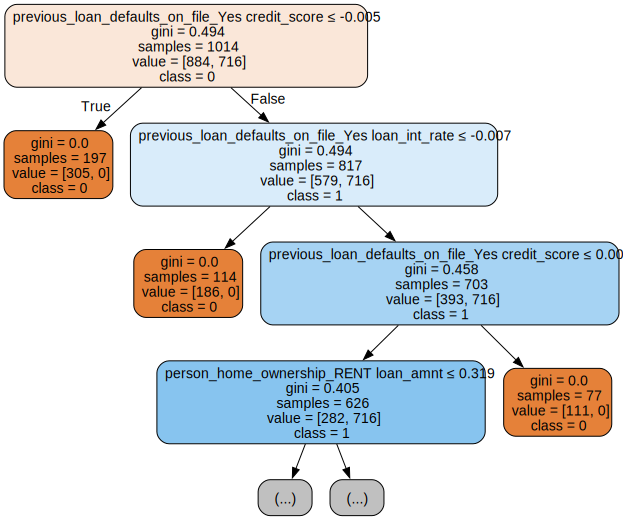

In [5]:
from sklearn.tree import export_graphviz
import graphviz

# 从pipeline中提取随机森林分类器
rf_classifier = pipeline.named_steps['classifier']

# 提取第一棵树
estimator = rf_classifier.estimators_[0]

# 获取特征名称
feature_names = (
    # 获取分类特征的名称
    pipeline.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out([
        'person_gender', 'person_education', 'person_home_ownership',
        'loan_intent', 'previous_loan_defaults_on_file'
    ]).tolist() +
    # 获取数值特征的名称
    [
        'person_age', 'person_income', 'person_emp_exp',
        'loan_amnt', 'loan_int_rate', 'loan_percent_income',
        'cb_person_cred_hist_length', 'credit_score'
    ]
)

# 获取多项式特征的名称
poly_feature_names = pipeline.named_steps['poly_features'].get_feature_names_out(feature_names)

# 导出树的结构为DOT格式
dot_data = export_graphviz(estimator,
                           out_file=None,
                           feature_names=poly_feature_names,
                           class_names=rf_classifier.classes_.astype(str),
                           filled=True,
                           rounded=True,
                           special_characters=True,
                           max_depth=3)  # 为了简化，可限制深度

# 使用graphviz渲染
graph = graphviz.Source(dot_data)
graph.render("decision_tree")

# 显示图像（在Jupyter Notebook中）
graph


使用Ensemble Model一个重要的好处是可以得到特征重要性。这使得特征工程可以更有针对性

但是特征重要性的可解释性较弱。

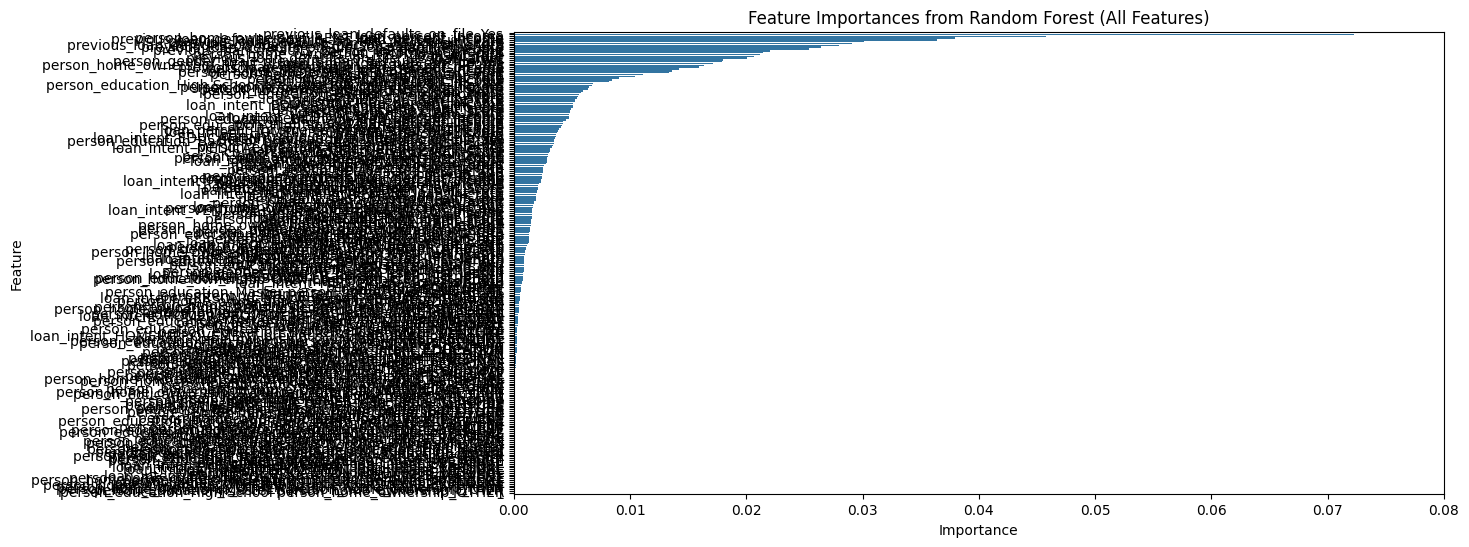

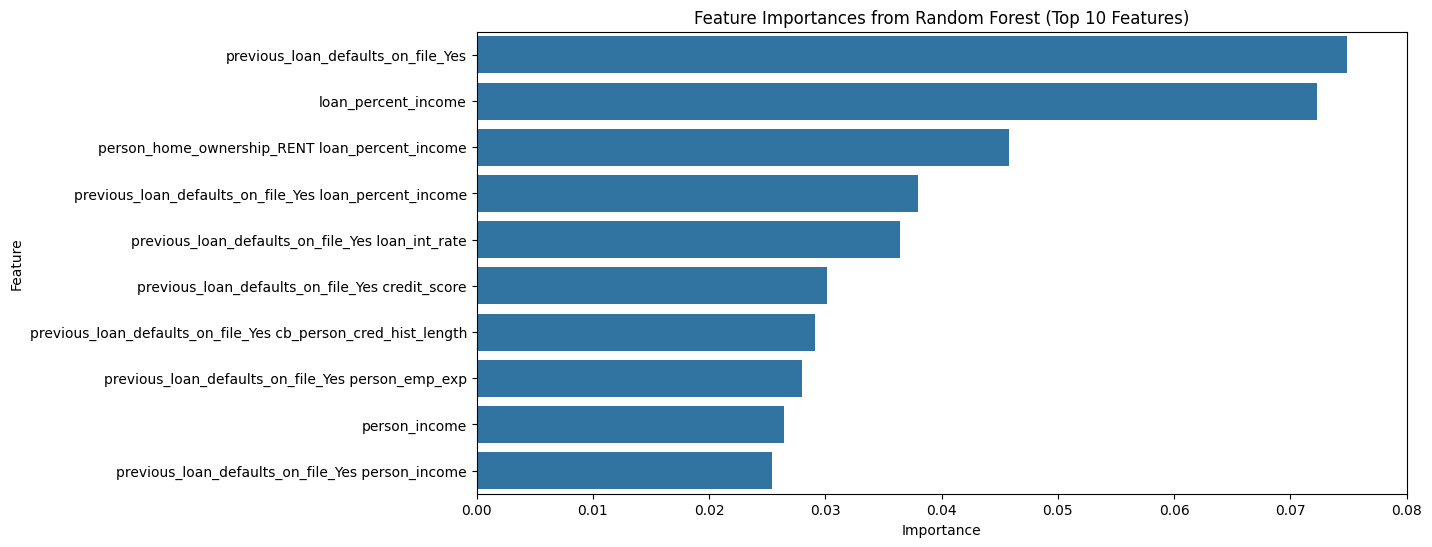

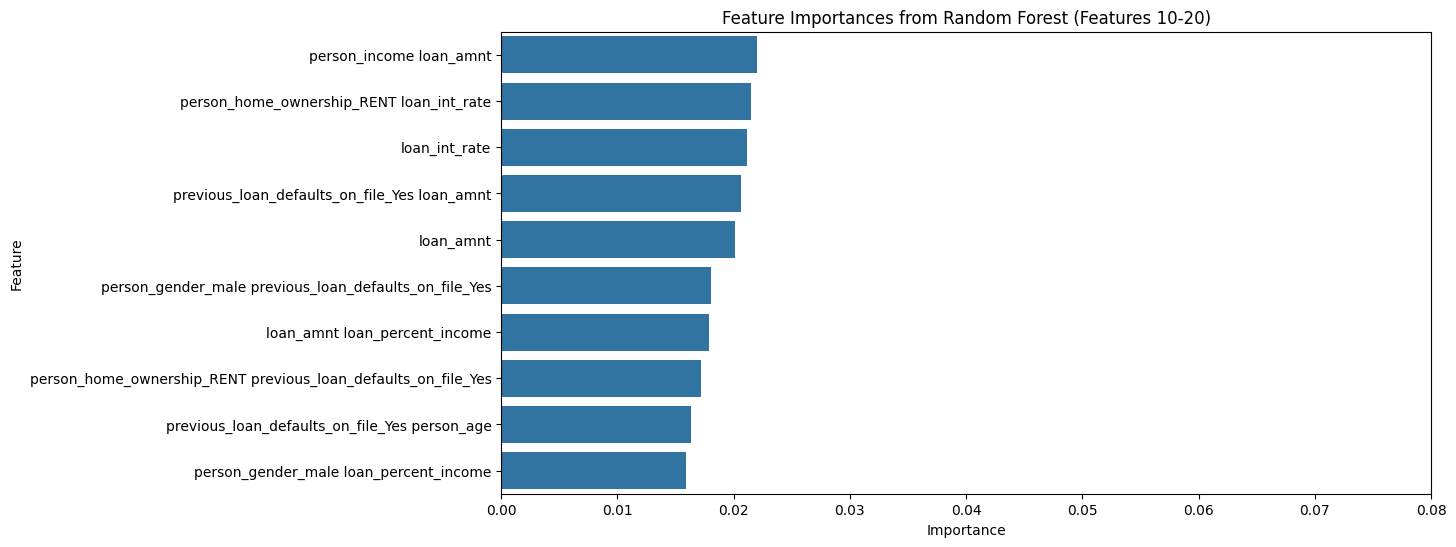

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 获取特征名称
# 获取所有特征名称
feature_names = (
    # 获取分类特征的名称
    pipeline.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out([
        'person_gender', 'person_education', 'person_home_ownership',
        'loan_intent', 'previous_loan_defaults_on_file'
    ]).tolist() +
    # 获取数值特征的名称
    [
        'person_age', 'person_income', 'person_emp_exp',
        'loan_amnt', 'loan_int_rate', 'loan_percent_income',
        'cb_person_cred_hist_length', 'credit_score'
    ]
)

# 获取多项式特征的名称
feature_names = pipeline.named_steps['poly_features'].get_feature_names_out(feature_names)


# 获取特征重要性
importances = pipeline.named_steps['classifier'].feature_importances_

# 创建特征重要性数据框
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 按重要性排序
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# 可视化特征重要性
# 绘制所有特征重要性
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances from Random Forest (All Features)')
plt.xlim(0, 0.08)
plt.show()

# 绘制Top 10特征重要性
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Feature Importances from Random Forest (Top 10 Features)')
plt.xlim(0, 0.08)
plt.show()

# 打印前10-20名重要特征
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.iloc[10:20])
plt.title('Feature Importances from Random Forest (Features 10-20)')
plt.xlim(0, 0.08)
plt.show()



**HW**：思考你如何在perceptron classifier和SVM获取特征重要性信息？

# 2. Ensemble Model调优
## 2.1 参数调优
群体参数：
- n_estimators: 森林中树的数量。越多越好，但会增加计算量。
- max_features: 每个树的特征选择方式。auto = sqrt(特征数量的平方根)。log2 = log2(特征数量)。特征越多，解释能力越强，单树越复杂，越容易过拟合。auto = sqrt。一般不调整这个

单classifier参数：
- max_depth: 每棵树的深度。深度越大，单树越复杂，越容易过拟合。
- min_samples_split: 决定树的最小分裂样本数。值越小，单树越复杂，越容易过拟合。
- min_samples_leaf：最终节点所需的最小样本数，值越小，单树越复杂，越容易过拟合。
- max_leaf_nodes: 最终节点最大数量，值越大，单树越复杂，越容易过拟合。
- criterion: 决定树的分类标准。gini = 基尼不纯度，entropy = 信息增益。

In [7]:
# 定义参数网格
param_grid = {
    'classifier__n_estimators': [200, 500, 1000], # 森林级别参数，决定森林数量
    'classifier__max_depth': [10, 20, 40],  # 单决策树参数，决定树的深度。深度越大，单树越复杂，越容易过拟合。
    'classifier__min_samples_split': [2, 5, 10], # 单决策树参数，决定树的最小分裂样本数。值越小，单树越复杂，越容易过拟合。
}

# 创建带有GridSearch的管道
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=3, 
                           scoring='accuracy',
                           n_jobs=6)

# 运行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best Parameters:", grid_search.best_params_)

# 使用最佳模型进行预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 评估最佳模型
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy after GridSearchCV: {accuracy:.2f}")

print("Classification Report after GridSearchCV:")
print(classification_report(y_test, y_pred))


Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 500}
Accuracy after GridSearchCV: 0.92
Classification Report after GridSearchCV:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       246
           1       0.90      0.90      0.90       154

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



**HW** 阅读上面的classifcation report， 你会做什么下一步的决策？ HINT：你的Grid Search应该怎么做？

## 2.2 Now You Try!

## 3 尝试不同的Ensemble Model【JC DEMO ONLY】

还有2个常见的ensemble model是GBDT和XGBoost。事实上在实际应用中，我常用的流程是特征工程+Logistic Classifer进行一轮特征初筛，XGBoost进行模型训练，并以AUC作为结果汇报。

这里我们用RF给出的最重要的100个特征，尝试用XGBoost进行训练

In [8]:
def get_feature_names(preprocessor, poly_features):
    # 获取数值和分类特征名称
    feature_names = (
        # 获取分类特征的名称
        preprocessor.named_transformers_['cat'].get_feature_names_out([
            'person_gender', 'person_education', 'person_home_ownership',
            'loan_intent', 'previous_loan_defaults_on_file'
        ]).tolist() +
        # 获取数值特征的名称
        [
            'person_age', 'person_income', 'person_emp_exp',
            'loan_amnt', 'loan_int_rate', 'loan_percent_income',
            'cb_person_cred_hist_length', 'credit_score'
        ]
    )
    
    # 获取多项式特征名称
    if poly_features:
        feature_names = poly_features.get_feature_names_out(feature_names)
    
    return feature_names

In [9]:
# 获取最重要的50个特征
feature_importances = pd.DataFrame(
    best_model.named_steps['classifier'].feature_importances_,
    index=get_feature_names(best_model.named_steps['preprocessor'], 
                          best_model.named_steps['poly_features']),
    columns=['importance']
).sort_values('importance', ascending=False)

# 获取前50个最重要特征的名称
top_features = feature_importances.head(100).index.tolist()

# 创建一个新的pipeline，只处理特征转换
preprocessing_pipeline = Pipeline([
    ('preprocessor', best_model.named_steps['preprocessor']),
    ('poly_features', best_model.named_steps['poly_features'])
])

# 使用preprocessing_pipeline转换数据
X_train_transformed = preprocessing_pipeline.fit_transform(X_train)
X_test_transformed = preprocessing_pipeline.transform(X_test)

# 转换为DataFrame并选择top 50特征
filtered_x_train = pd.DataFrame(
    X_train_transformed,
    columns=get_feature_names(best_model.named_steps['preprocessor'], 
                            best_model.named_steps['poly_features'])
)[top_features]

filtered_x_test = pd.DataFrame(
    X_test_transformed,
    columns=get_feature_names(best_model.named_steps['preprocessor'],
                            best_model.named_steps['poly_features'])
)[top_features]

print(f"筛选后的特征数量: {len(top_features)}")
print('\n'.join(top_features))
print(f"筛选后训练集形状: {filtered_x_train.shape}")
print(f"筛选后测试集形状: {filtered_x_test.shape}")

筛选后的特征数量: 100
person_home_ownership_RENT loan_percent_income
previous_loan_defaults_on_file_Yes
loan_percent_income
previous_loan_defaults_on_file_Yes cb_person_cred_hist_length
previous_loan_defaults_on_file_Yes loan_percent_income
previous_loan_defaults_on_file_Yes loan_int_rate
previous_loan_defaults_on_file_Yes loan_amnt
previous_loan_defaults_on_file_Yes person_income
previous_loan_defaults_on_file_Yes person_emp_exp
person_income loan_amnt
person_income
person_home_ownership_RENT previous_loan_defaults_on_file_Yes
previous_loan_defaults_on_file_Yes credit_score
previous_loan_defaults_on_file_Yes person_age
person_home_ownership_RENT loan_int_rate
loan_int_rate
person_gender_male loan_percent_income
loan_amnt loan_percent_income
loan_amnt
person_home_ownership_RENT loan_amnt
person_gender_male previous_loan_defaults_on_file_Yes
person_home_ownership_RENT person_income
person_gender_male person_income
person_gender_male loan_int_rate
person_income loan_percent_income
loan_int_rate 

In [10]:
from xgboost import XGBClassifier  # https://xgboost.readthedocs.io/en/stable/

# 创建XGBoost模型
xgb_model = XGBClassifier(random_state=42)

# 使用GridSearchCV进行参数调优
xgb_grid_search = GridSearchCV(
    xgb_model,
    param_grid={
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [3, 5, 7, 9], 
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    cv=3,
    scoring='roc_auc',
    n_jobs=6
)

# 在筛选后的训练数据上训练模型
xgb_grid_search.fit(filtered_x_train, y_train)

# 输出最佳参数
print("XGBoost最佳参数:", xgb_grid_search.best_params_)

# 使用最佳模型在筛选后的测试数据上进行预测
xgb_best_model = xgb_grid_search.best_estimator_
xgb_y_pred = xgb_best_model.predict(filtered_x_test)





XGBoost最佳参数: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}



XGBoost准确率: 0.93

XGBoost分类报告:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       246
           1       0.91      0.90      0.91       154

    accuracy                           0.93       400
   macro avg       0.93      0.92      0.93       400
weighted avg       0.93      0.93      0.93       400



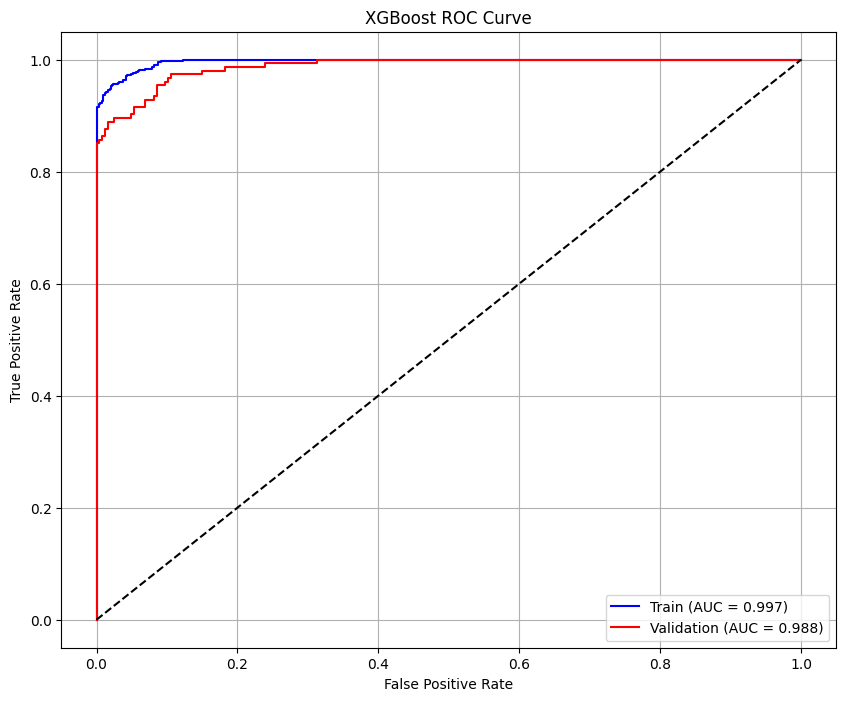

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score


# 汇报F1 Score
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
print(f"\nXGBoost准确率: {xgb_accuracy:.2f}")

print("\nXGBoost分类报告:")
print(classification_report(y_test, xgb_y_pred))

# 计算训练集和测试集的预测概率
xgb_train_probs = xgb_best_model.predict_proba(filtered_x_train)[:, 1]
xgb_test_probs = xgb_best_model.predict_proba(filtered_x_test)[:, 1]


# 计算ROC曲线的假正率和真正率
train_fpr, train_tpr, _ = roc_curve(y_train, xgb_train_probs)
test_fpr, test_tpr, _ = roc_curve(y_test, xgb_test_probs)

# 计算AUC值
train_auc = roc_auc_score(y_train, xgb_train_probs)
test_auc = roc_auc_score(y_test, xgb_test_probs)

# 绘制ROC曲线
plt.figure(figsize=(10, 8))
plt.plot(train_fpr, train_tpr, label=f'Train (AUC = {train_auc:.3f})', color='blue')
plt.plot(test_fpr, test_tpr, label=f'Validation (AUC = {test_auc:.3f})', color='red')
plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend()
plt.grid(True)
plt.show()